In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from opxrd.wrapper import OpXRD

# ------------------------------------------------------------

smoltest_dirpath = '/home/daniel/aimat/data/opXRD/test_smol'
bigtest_dirpath = '/home/daniel/aimat/data/opXRD/test'
full_dirpath = '/home/daniel/aimat/data/opXRD/final/'
database = OpXRD.load_project_list(root_dirpath=full_dirpath)

- Loading databases from /home/daniel/aimat/data/opXRD/test_smol
[2024-12-23 16:26:36]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test_smol/USC-partial


100% (174 of 174) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000


[2024-12-23 16:26:36]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test_smol/USC-partial
[2024-12-23 16:26:36]: Successfully extracted 174 patterns from 174/174 xrd files
[2024-12-23 16:26:36]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test_smol/CNRS-partial


100% (27 of 27) |########################| Elapsed Time: 0:00:00 Time:  0:00:000000


[2024-12-23 16:26:36]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test_smol/CNRS-partial
[2024-12-23 16:26:36]: Successfully extracted 27 patterns from 27/27 xrd files


In [3]:
from opxrd.analysis import DatabaseAnalyser

analyser = DatabaseAnalyser(databases=database, output_dirpath='/tmp/opxrd_analysis')

---> Reference Twin Gaussian fourier transform

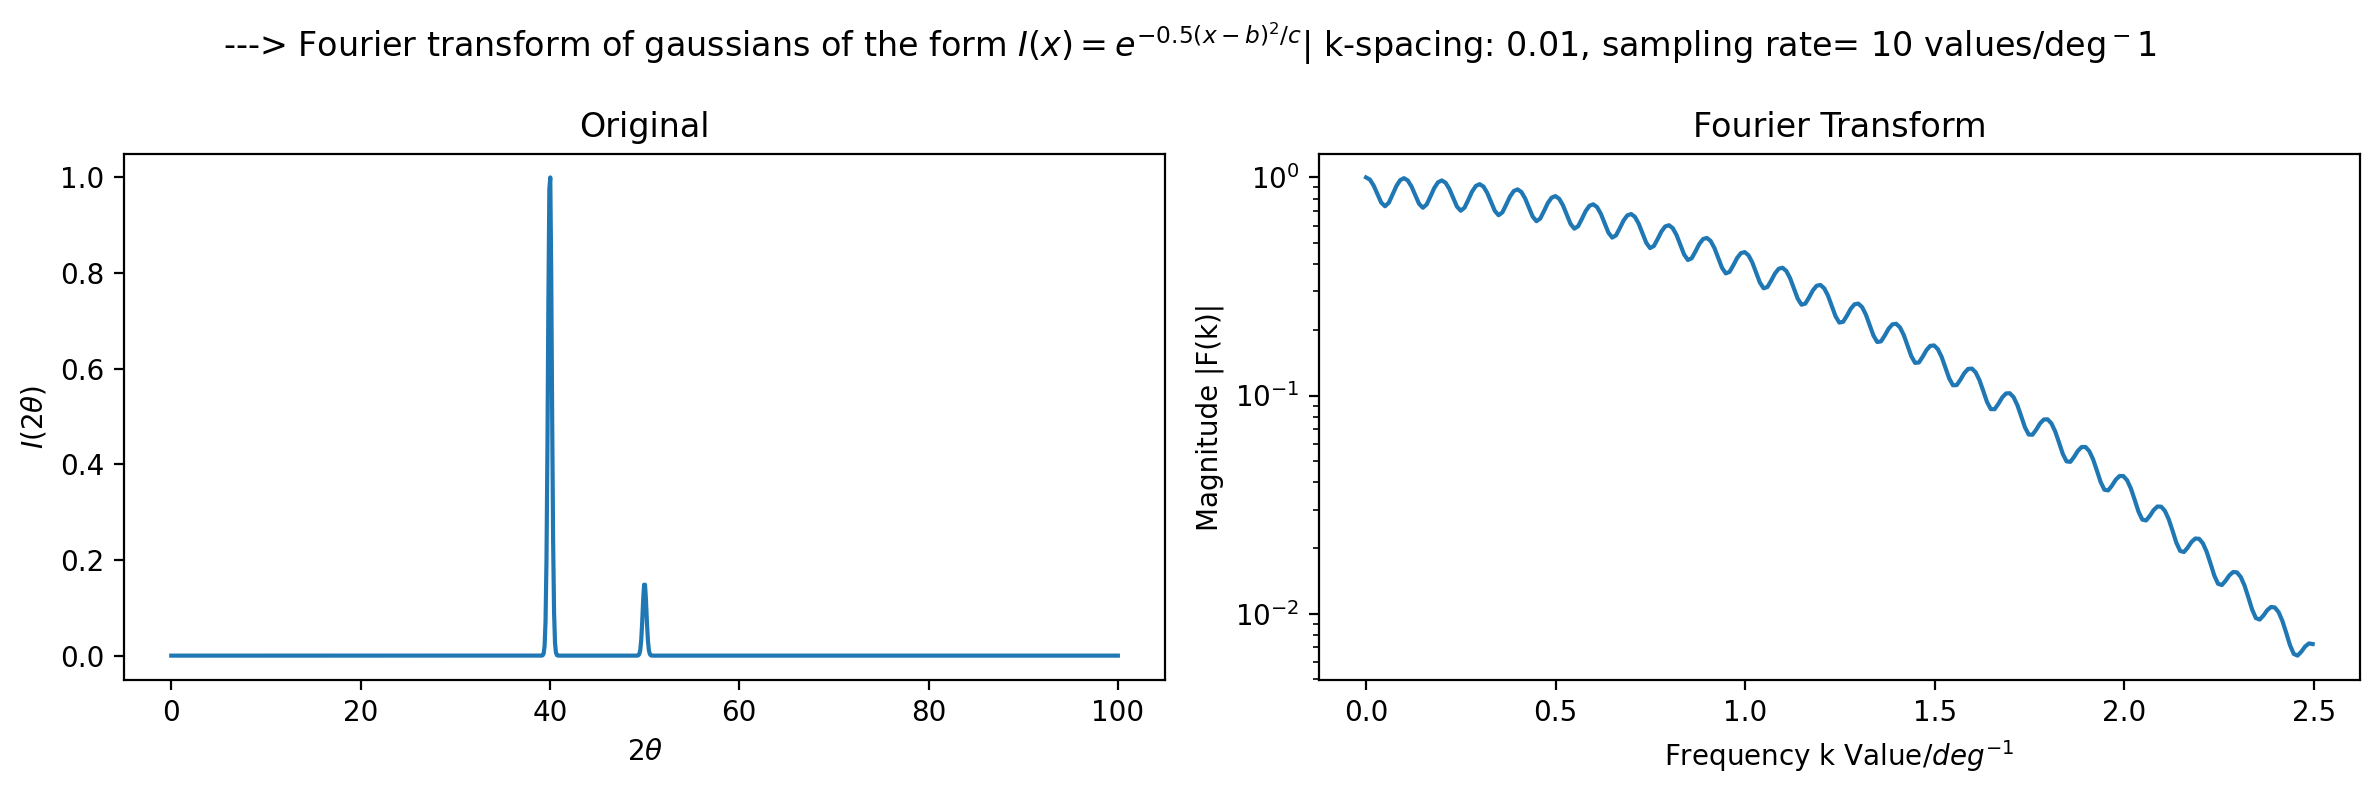

$f(x) = \delta(x-a_1)+\delta(x-a_2) \implies \hat{f}(k) = e^{ika_1} + e^{ika_2}$  <br />$|\hat{f}(k)| = 2 | \sin(k\Delta a/2)|$, $\Delta a = a_1 - a_2$

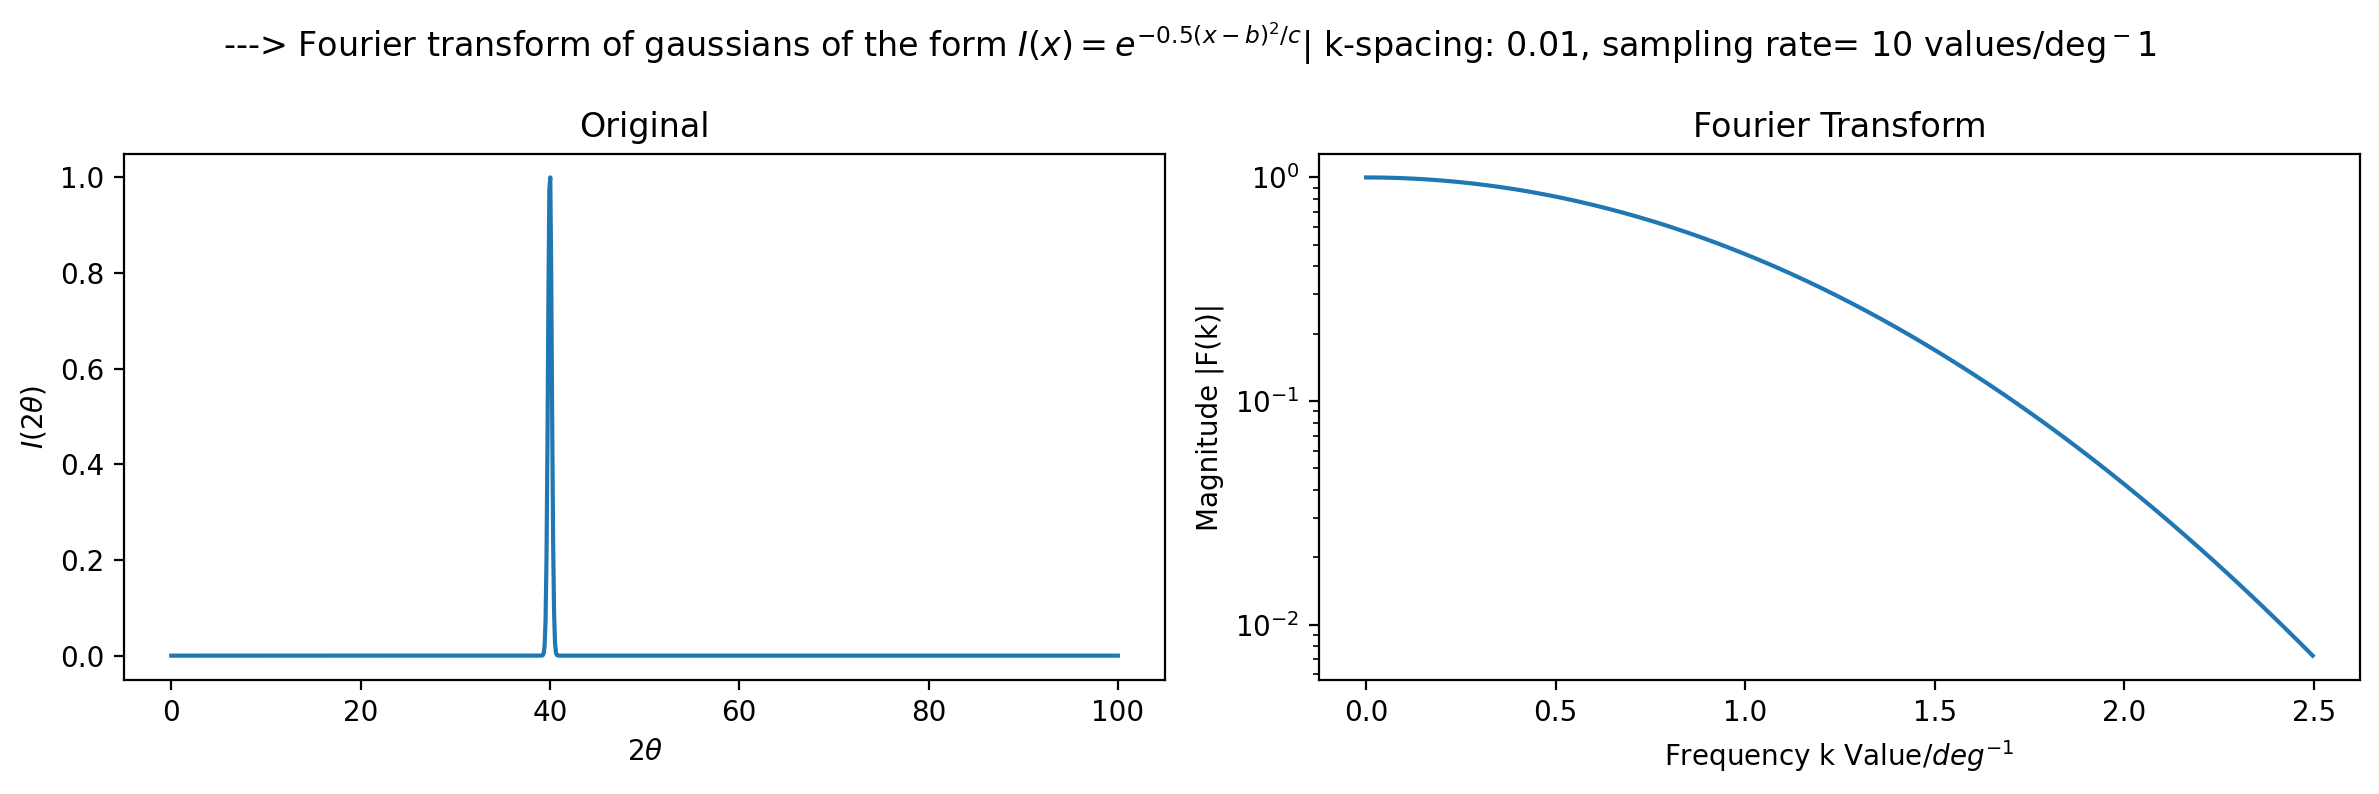

$f(x) = \delta(x-a_1)+\delta(x-a_2) \implies \hat{f}(k) = e^{ika_1} + e^{ika_2}$  <br />$|\hat{f}(k)| = 2 | \sin(k\Delta a/2)|$, $\Delta a = a_1 - a_2$

In [4]:
from opxrd.analysis.tools import print_text

print_text('---> Reference Twin Gaussian fourier transform')
analyser.plot_reference_fourier(b1=40, b2=50)
analyser.plot_reference_fourier(b1=40, b2=50, B=0)

---> Summed USC data fourier transform

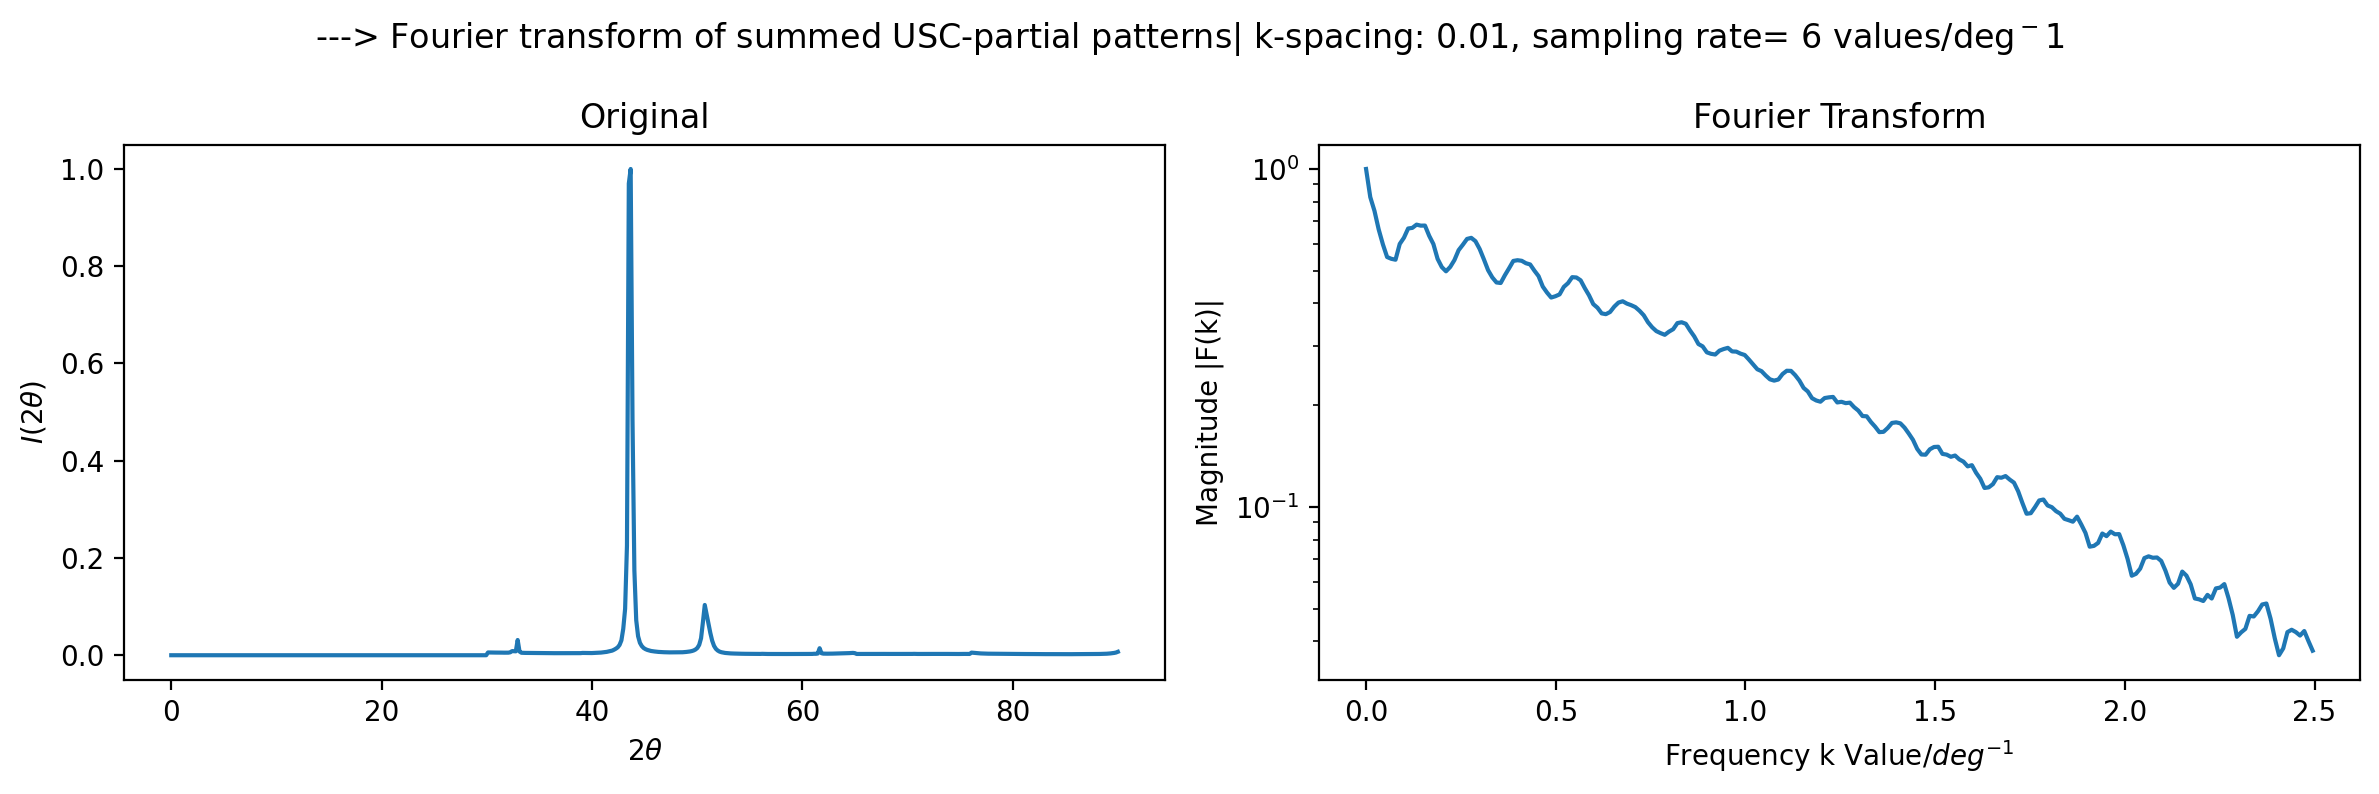

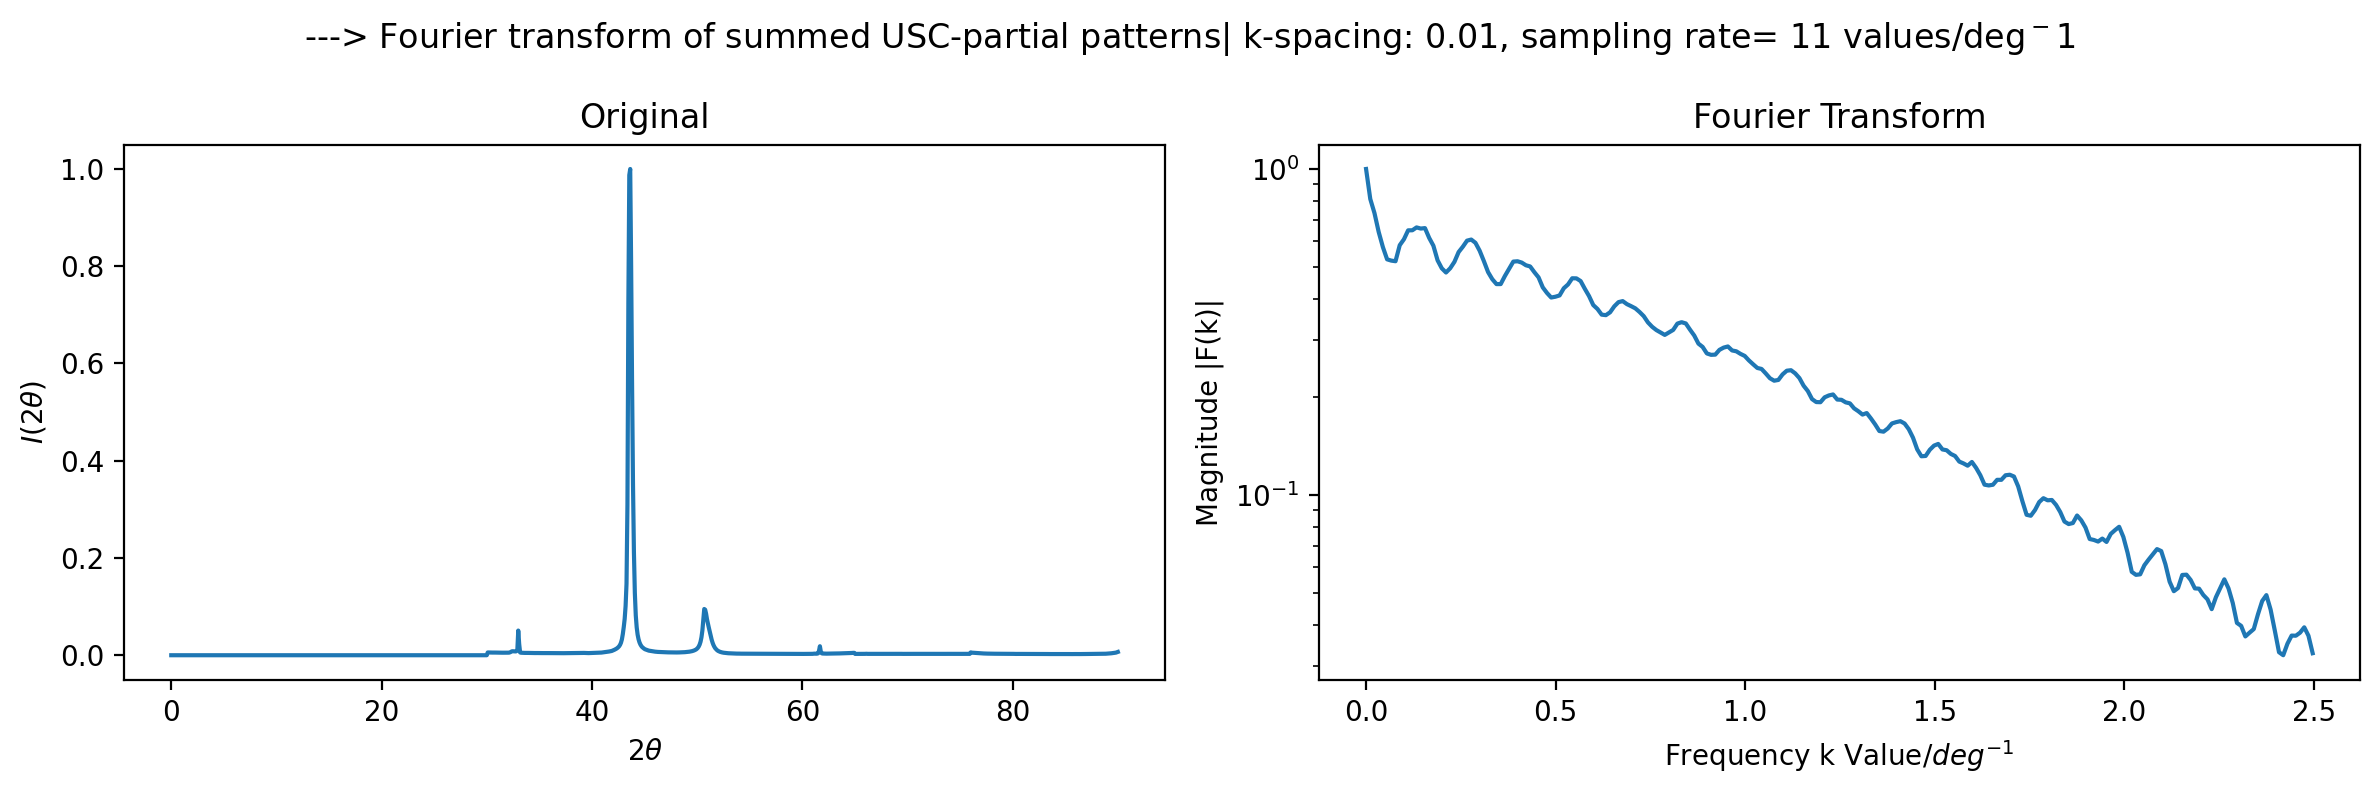

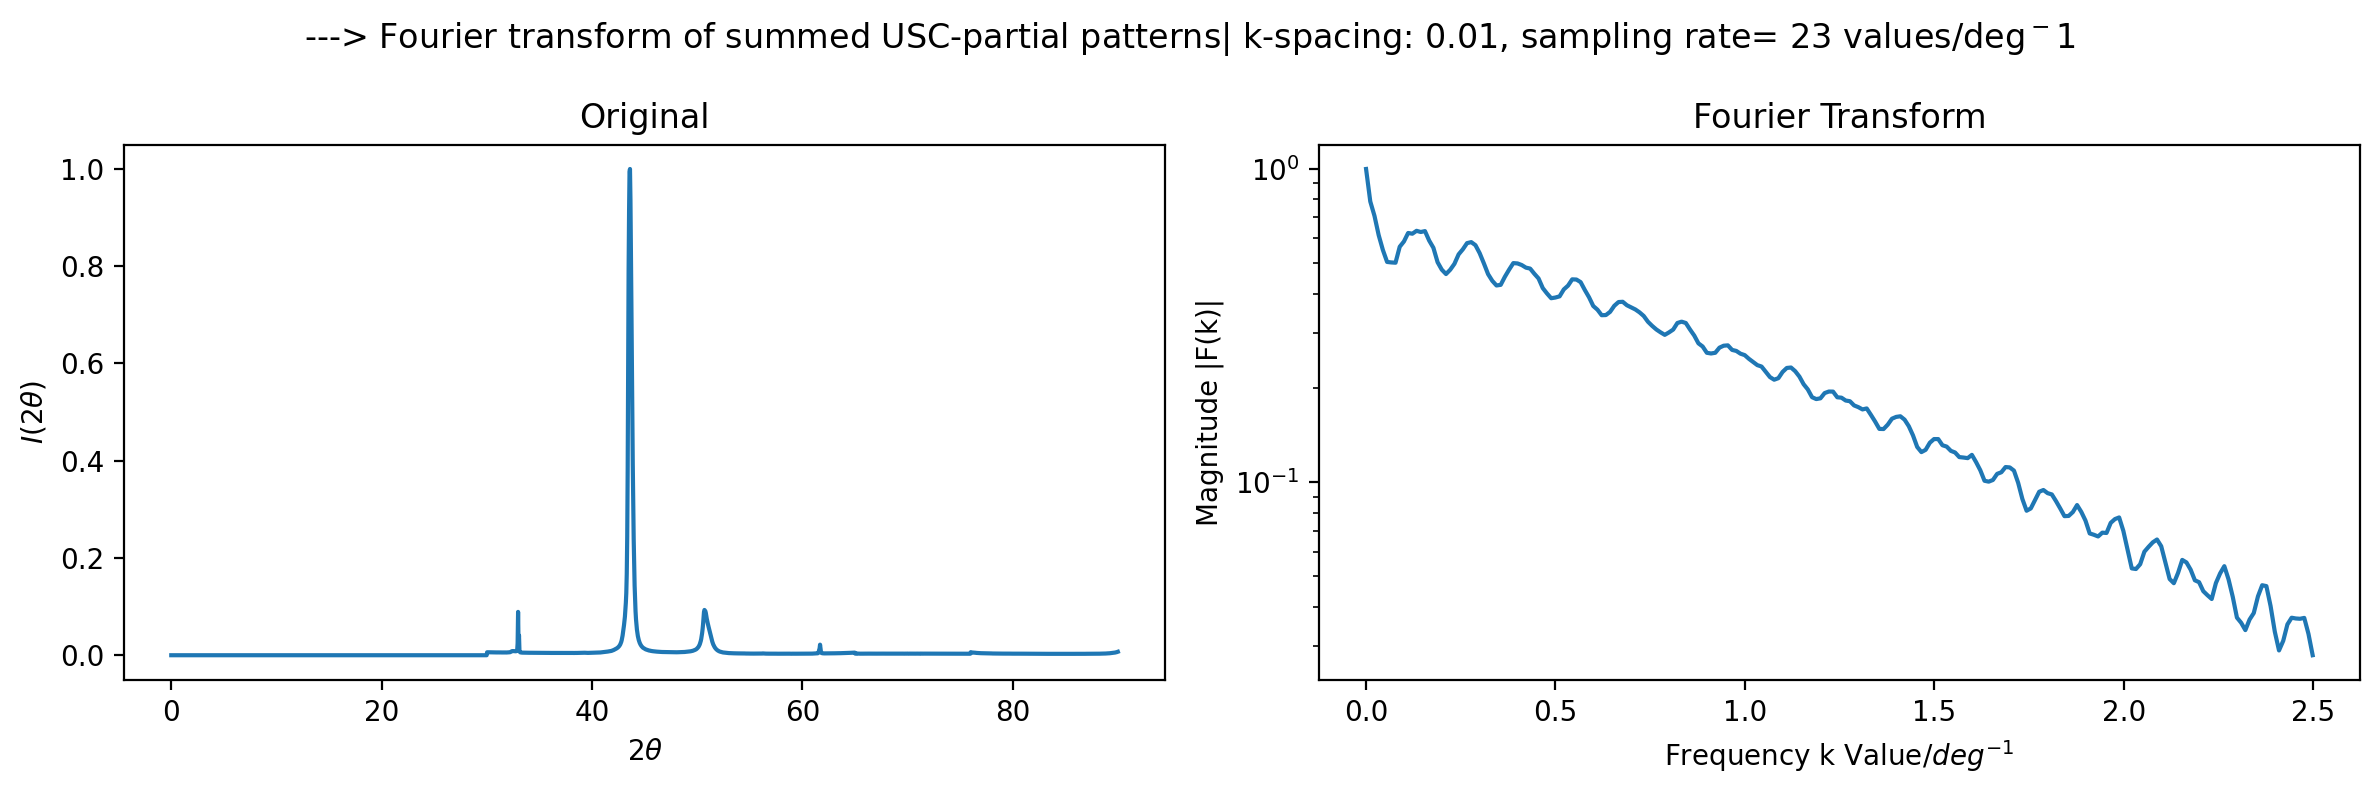

In [5]:
print_text('---> Summed USC data fourier transform')
analyser.plot_opxrd_fourier(combine_plots=False, filter_dbs='USC-partial', n_entries=512)
analyser.plot_opxrd_fourier(combine_plots=False, filter_dbs='USC-partial', n_entries=1024)
analyser.plot_opxrd_fourier(combine_plots=False, filter_dbs='USC-partial', n_entries=2048)

---> Fourier transforms of opXRD contributions in single figure

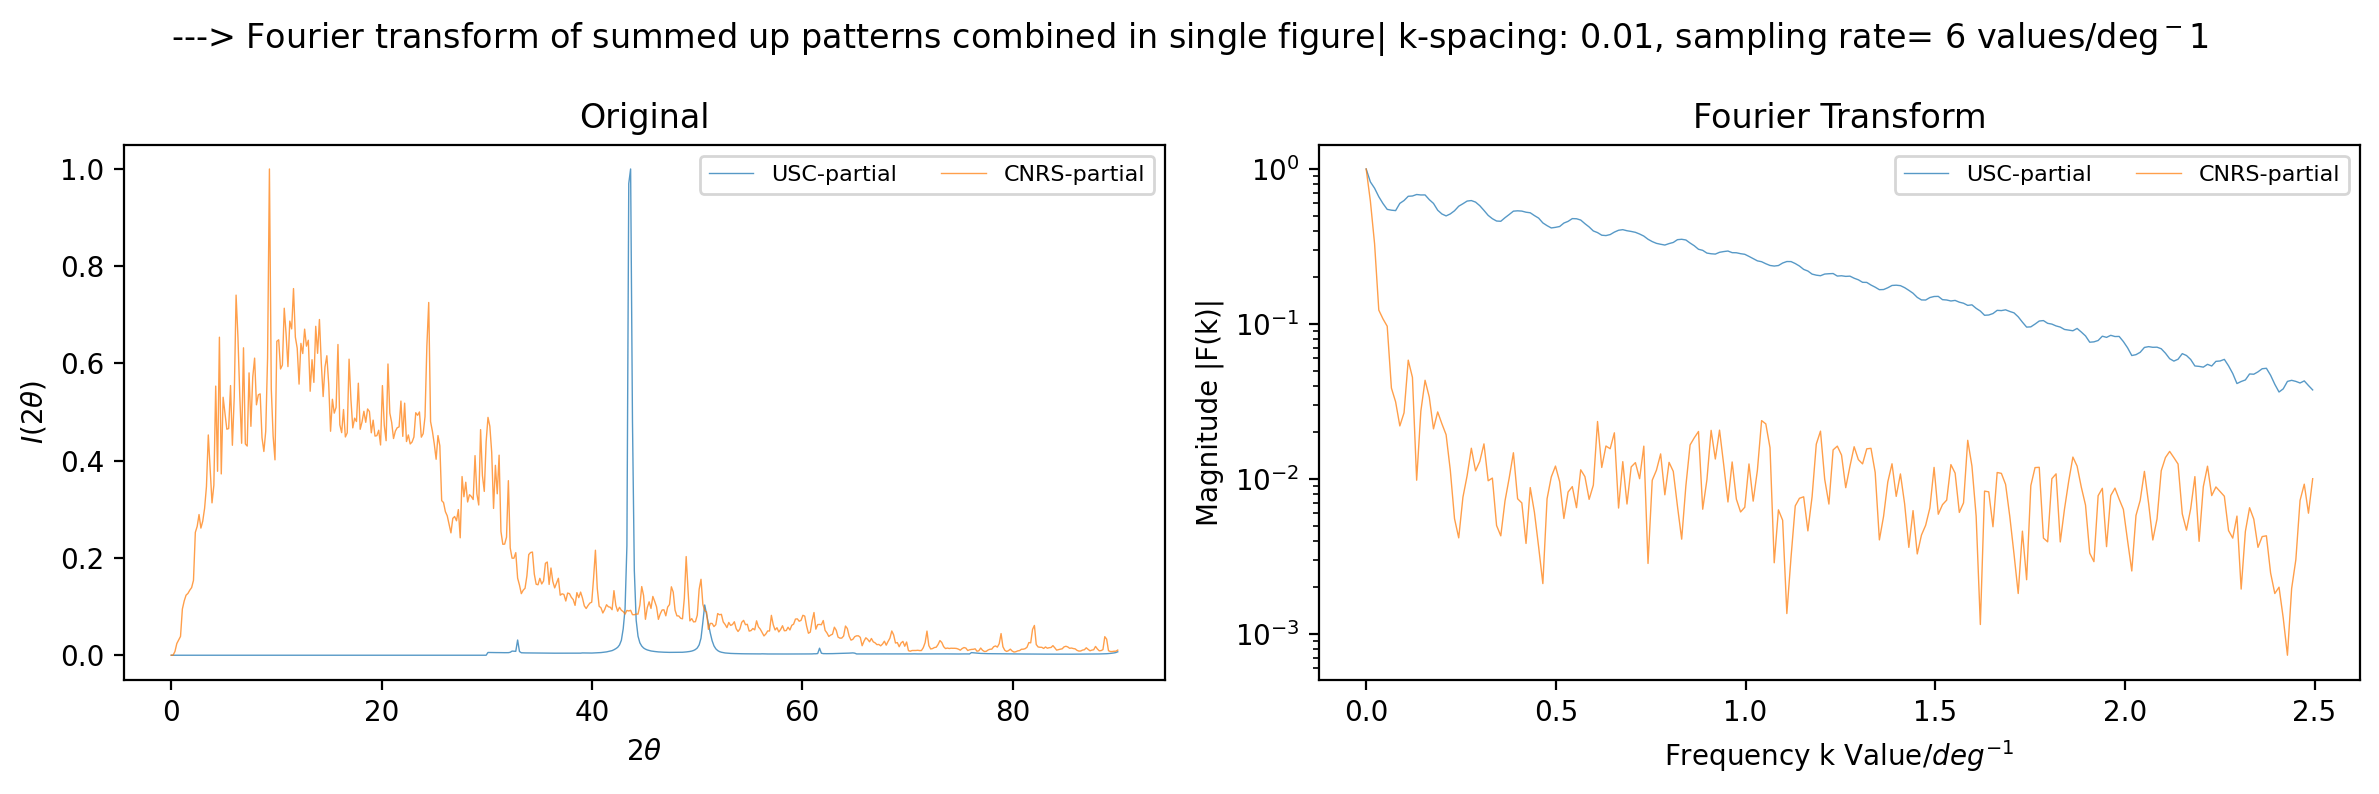

---> Fourier transforms of opXRD contributions in individual figures

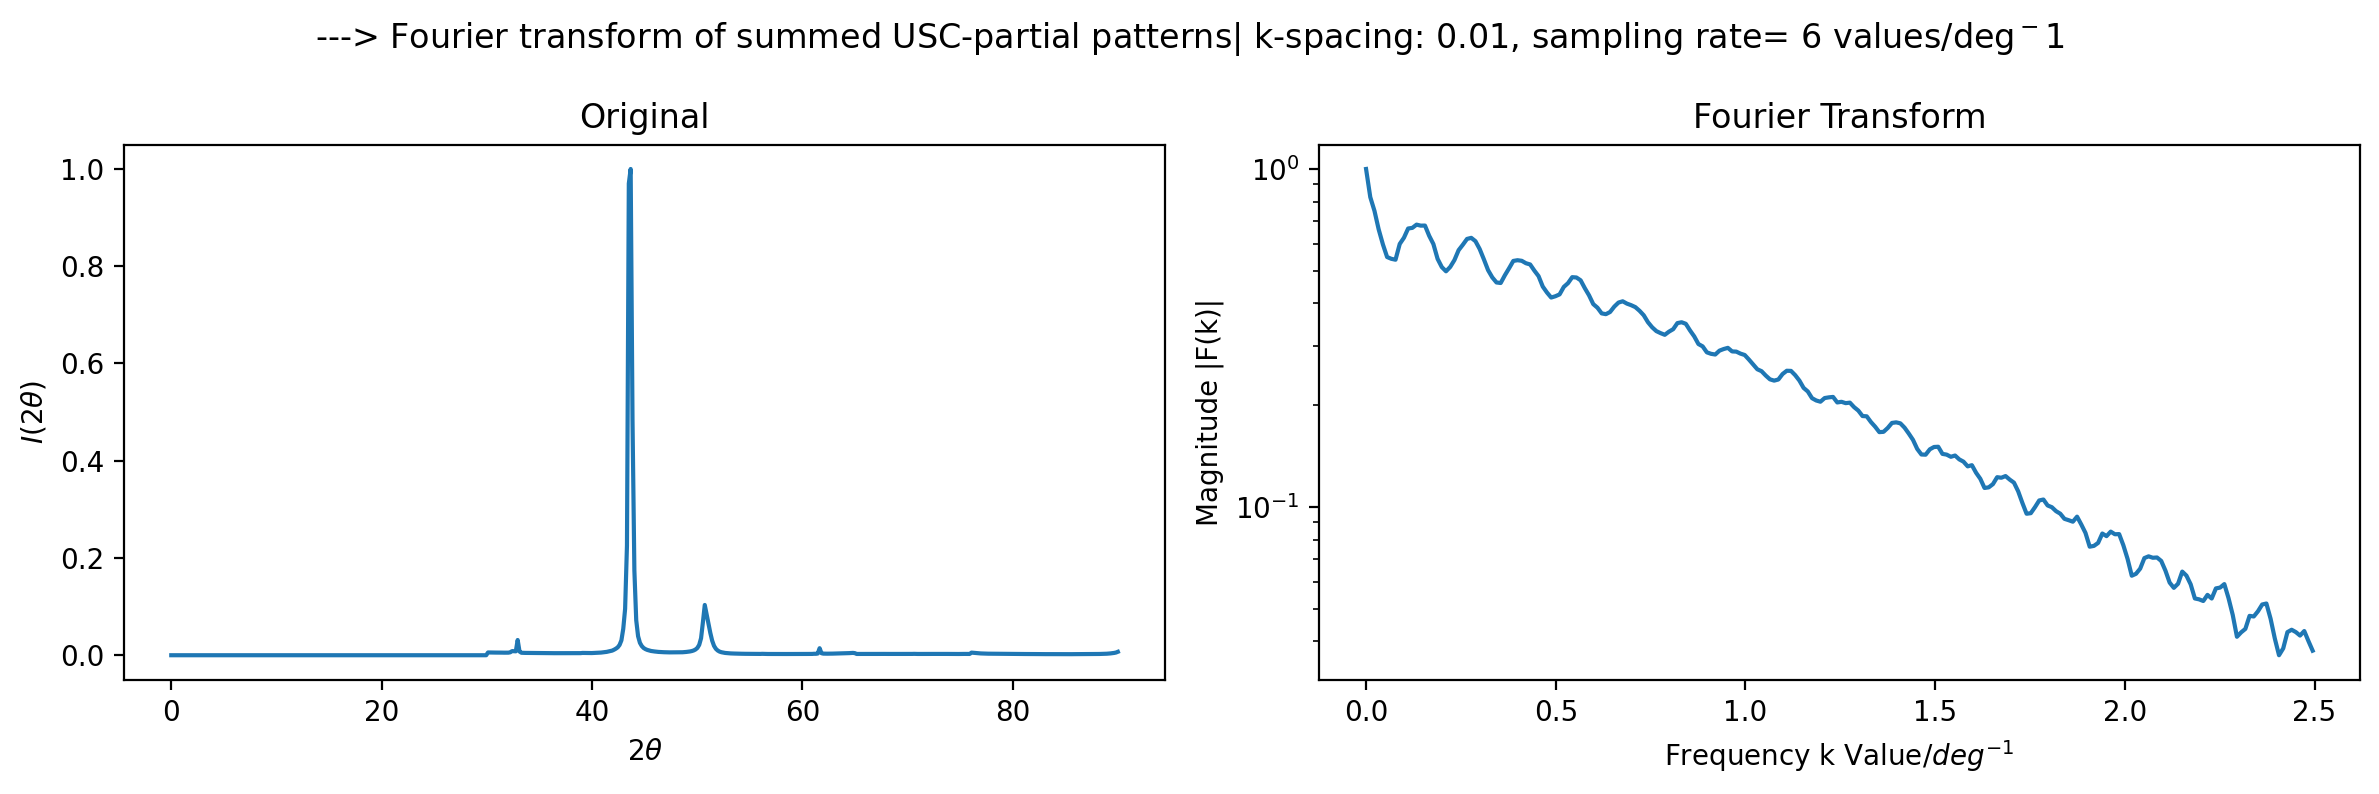

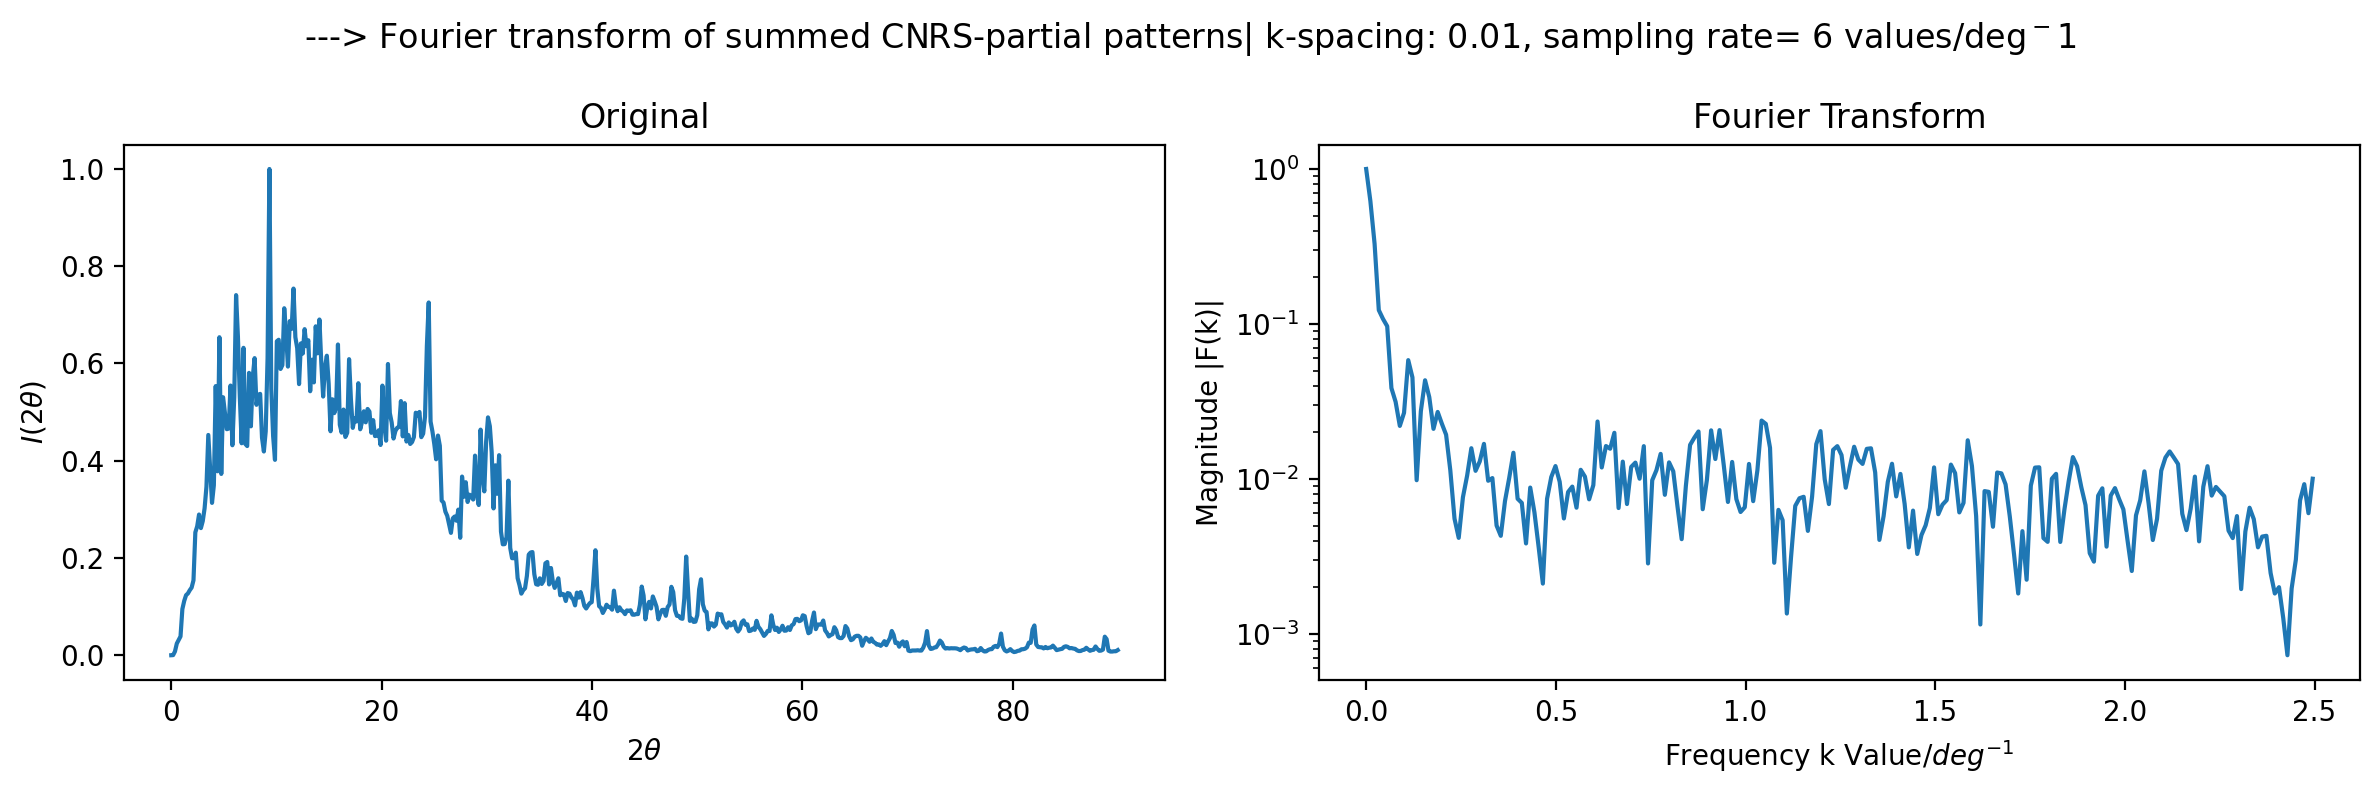

In [6]:
print_text('---> Fourier transforms of opXRD contributions in single figure')
analyser.plot_opxrd_fourier(combine_plots=True)
print_text('---> Fourier transforms of opXRD contributions in individual figures')
analyser.plot_opxrd_fourier(combine_plots=False)

---> Combined pattern plot for databaes ['a:USC-partial', 'b:CNRS-partial'] | No. patterns = 10

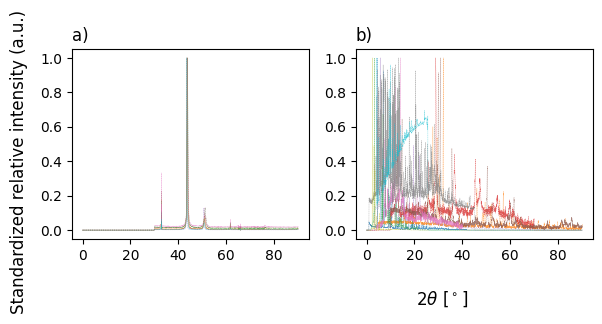

In [7]:
analyser.plot_in_single(limit_patterns=10)

---> Combined pattern plot for databaes ['a:USC-partial', 'b:CNRS-partial'] | No. patterns = 50

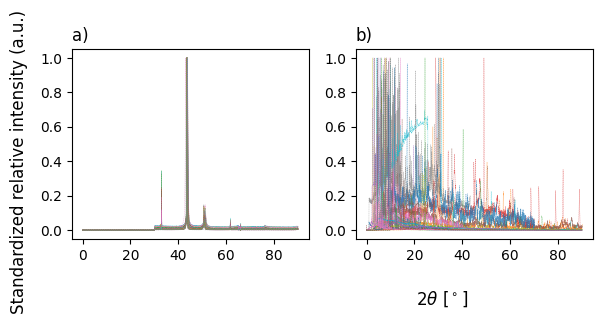

In [8]:
analyser.plot_in_single(limit_patterns=50)

---> Combined pattern plot for databaes ['a:USC-partial', 'b:CNRS-partial'] | No. patterns = 100

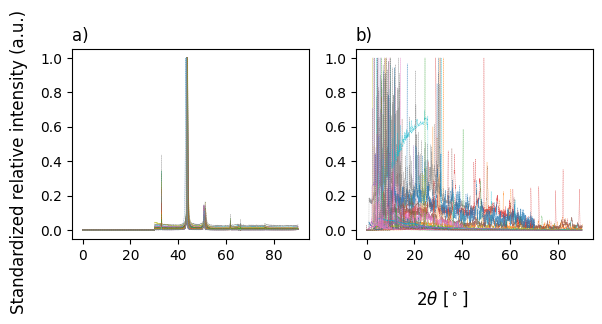

In [9]:
analyser.plot_in_single(limit_patterns=100)

---> Combined pattern plot for databaes ['a:USC-partial', 'b:CNRS-partial'] | No. patterns = 1000

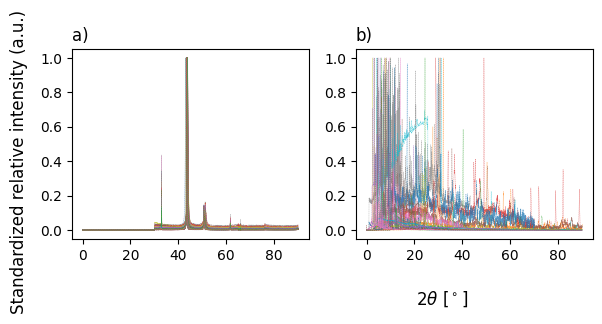

In [10]:
analyser.plot_in_single(limit_patterns=1000)

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for USC-partial | No. patterns = 174
[Debug]: Performing PCA for CNRS-partial | No. patterns = 27


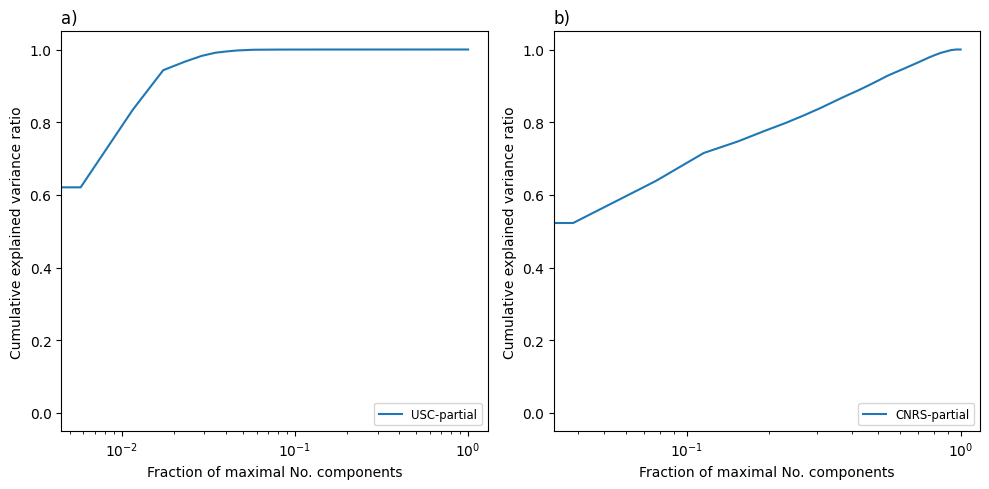

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for USC-partial | No. patterns = 174
[Debug]: Performing PCA for CNRS-partial | No. patterns = 27


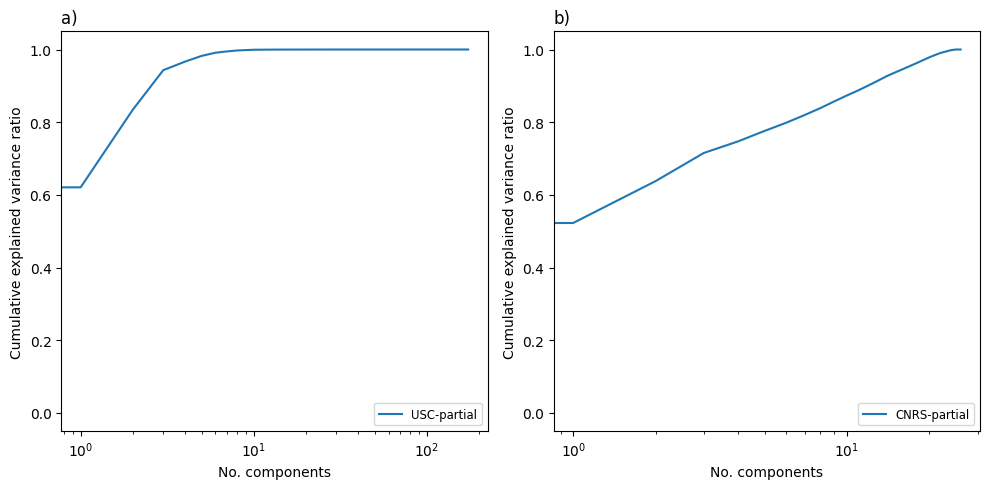

In [11]:
analyser.plot_effective_components()
analyser.plot_effective_components(use_fractions=False)

---> Histogram of general information on opXRD

/home/daniel/aimat/xrdpattern/xrdpattern/pattern/visualization.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(spg_formulas, rotation=90)


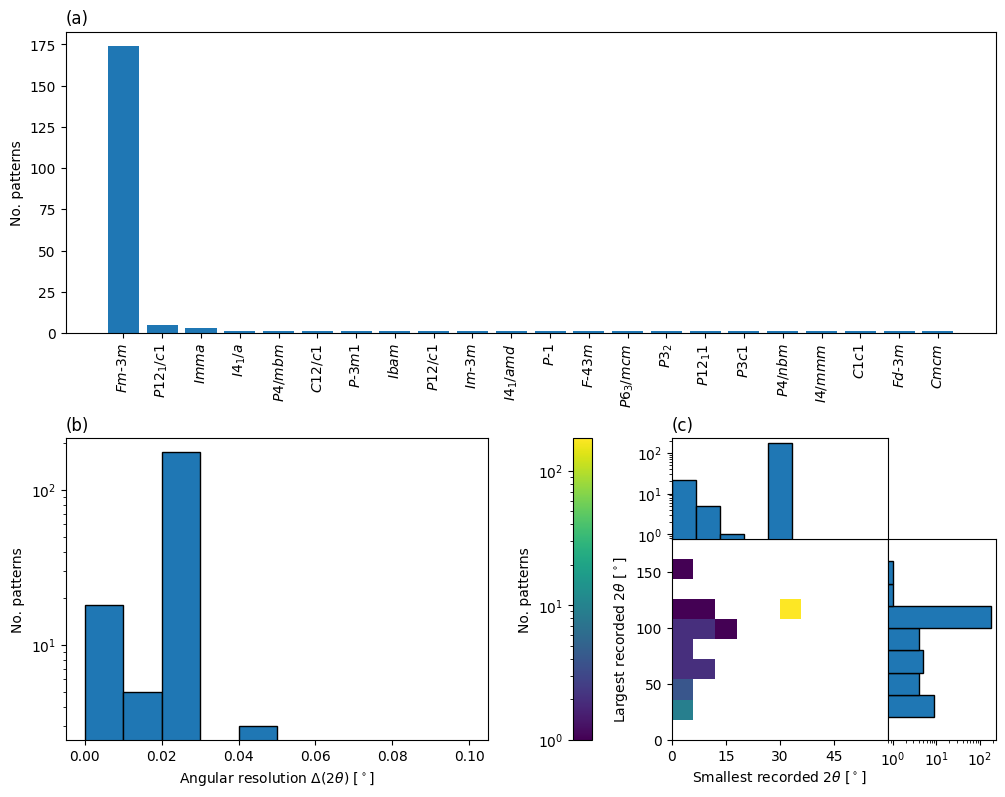

In [12]:
analyser.plot_histogram()

In [17]:
analyser.show_label_fractions()
analyser.print_total_counts()

---> Overview of label fractions per contribution

+--------------+----------------+-------+-----------+---------------+---------------+
|              |   No. patterns |   spg |   lattice |   atom_coords |   composition |
|--------------+----------------+-------+-----------+---------------+---------------|
| USC-partial  |            174 |     1 |  0.994253 |      0        |      1        |
| CNRS-partial |             27 |     1 |  1        |      0.814815 |      0.814815 |
+--------------+----------------+-------+-----------+---------------+---------------+


---> Total pattern counts in opXRD

Total number of patterns = 201
Number of labeled patterns = 201


In [15]:
print('asdf')

asdf
